In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)


In [2]:
deliveries = pd.read_csv(r'F:\t20 data\t20 csv\Cricket_Data\t201.csv')

In [3]:
df = deliveries.copy() # make a copy of the dataframe
df = df.drop(columns=['replacements', 'review_by', 'review_umpire', 'review_batter','review_decision']) # drop unnecessary columns

consistent_teams = ['India', 'Australia', 'England', 'South Africa', 'Pakistan', 'New Zealand', 'West Indies', 'Sri Lanka', 'Bangladesh', 'Afghanistan'] # list of consistent teams

df = df[df['bowling_team'].isin(consistent_teams)] # filter the dataframe for consistent teams
df = df[df['batting_team'].isin(consistent_teams)] # filter the dataframe for consistent teams

In [4]:
df.columns

Index(['batter', 'bowler', 'non_striker', 'ball_number', 'batter_runs',
       'extras_runs', 'total_runs', 'wicket_kind', 'player_out', 'wicket_flag',
       'batting_team', 'bowling_team', 'innings', 'over', 'team', 'match_id',
       'venue', 'wides', 'legbyes', 'noballs', 'byes', 'penalty'],
      dtype='object')

In [5]:
df['wicket_kind'].unique()

array(['0', 'caught', 'run out', 'stumped', 'lbw', 'caught and bowled',
       'bowled', 'obstructing the field', 'hit wicket', 'retired hurt'],
      dtype=object)

In [6]:
def is_bowlers_wicket(player_out, wicket_kind):
  if type(player_out) == str:
    if wicket_kind not in ['run out', 'retired hurt', '0', 'obstructing the field']:
      return 1
    else:
      return 0
  else:
    return 0


In [7]:
df['isbowlerwk'] = df.apply(lambda x: is_bowlers_wicket(x['player_out'], x['wicket_kind']), axis=1)

In [8]:
def get_phase(over): # function to get the phase of the match
    if over <= 6:
        return 'Powerplay' 
    elif over < 15:
        return 'Middle Overs'
    else:
        return 'Death Overs'

In [9]:
df['phase'] = df['over'].apply(get_phase) # apply the function to get the phase of the match

In [ ]:
def bowlerstats(df, current_phase, current_innings):

  df = df[df.phase == current_phase]
  df = df[df.innings == current_innings]
  df.reset_index(drop=True, inplace=True)
  

  df['isdot'] = df['total_runs'].apply(lambda x: 1 if x == 0 else 0) # create a column to check if the ball was a dot ball
  
  df['isone'] = df['total_runs'].apply(lambda x: 1 if x == 1 else 0) # create a column to check if the ball was a single
  
  df['istwo'] = df['total_runs'].apply(lambda x: 1 if x == 2 else 0) # create a column to check if the ball was a double
  
  df['isthree'] = df['total_runs'].apply(lambda x: 1 if x == 3 else 0) # create a column to check if the ball was a triple
  
  df['isfour'] = df['total_runs'].apply(lambda x: 1 if x == 4 else 0)  # create a column to check if the ball was a boundary
  
  df['issix'] = df['total_runs'].apply(lambda x: 1 if x == 6 else 0) # create a column to check if the ball was a six
  
  runs = pd.DataFrame(df.groupby('bowler')['total_runs'].sum()).reset_index().rename(columns={'total_runs': 'runs_conceded'}) # get the total runs conceded by the bowler
  
  innings = pd.DataFrame(df.groupby('bowler')['match_id'].nunique()).reset_index().rename(columns={'match_id': 'innings'}) # get the number of innings bowled by the bowler
  
  balls = pd.DataFrame(df.groupby('bowler')['ball_number'].count()).reset_index().rename(columns={'ball_number': 'balls'}) # get the number of balls bowled by the bowler
  
  dismissals = pd.DataFrame(df.groupby('bowler')['isbowlerwk'].sum()).reset_index().rename(columns={'isbowlerwk': 'wickets'}) # get the number of wickets taken by the bowler
  
  dots = pd.DataFrame(df.groupby('bowler')['isdot'].sum()).reset_index().rename(columns={'isdot': 'dots'}) # get the number of dot balls bowled by the bowler
  
  ones = pd.DataFrame(df.groupby('bowler')['isone'].sum()).reset_index().rename(columns={'isone': 'ones'}) # get the number of singles conceded by the bowler
  
  twos = pd.DataFrame(df.groupby('bowler')['istwo'].sum()).reset_index().rename(columns={'istwo': 'twos'}) # get the number of doubles conceded by the bowler
  
  threes = pd.DataFrame(df.groupby('bowler')['isthree'].sum()).reset_index().rename(columns={'isthree': 'threes'}) # get the number of triples conceded by the bowler 
  
  fours = pd.DataFrame(df.groupby('bowler')['isfour'].sum()).reset_index().rename(columns={'isfour': 'fours'}) # get the number of boundaries conceded by the bowler
  
  sixes = pd.DataFrame(df.groupby('bowler')['issix'].sum()).reset_index().rename(columns={'issix': 'sixes'}) # get the number of sixes conceded by the bowler
  
  bowler_df = pd.merge(innings, balls, on='bowler', how='left').merge(runs, on='bowler').merge(dismissals, on='bowler').merge(dots, on='bowler').merge(ones, on='bowler').merge(twos, on='bowler').merge(threes, on='bowler').merge(fours, on='bowler').merge(sixes, on='bowler')

  bowler_df['dot%'] = bowler_df.apply(lambda x: (x['dots'] / x['balls']) * 100, axis=1) # calculate the dot ball percentage

  bowler_df['ECO'] = round(bowler_df['runs_conceded'] / (bowler_df['balls'] / 6), 2) # calculate the economy rate
  bowler_df['Avg'] = round(bowler_df['runs_conceded'] / bowler_df['wickets'].replace(0, np.nan), 2) # calculate the bowling average
  bowler_df['SR'] = round(bowler_df['balls'] / bowler_df['wickets'].replace(0, np.nan), 2) # calculate the strike rate
  bowler_df['Boundary%'] = round(((bowler_df['fours'] + bowler_df['sixes']) / bowler_df['balls']) * 100, 2) # calculate the boundary percentage
  bowler_df['1s%'] = round((bowler_df['ones'] / bowler_df['balls']) * 100, 2) # calculate the percentage of singles conceded
  bowler_df['2s%'] = round((bowler_df['twos'] / bowler_df['balls']) * 100, 2) # calculate the percentage of doubles conceded
  bowler_df['3s%'] = round((bowler_df['threes'] / bowler_df['balls']) * 100, 2) # calculate the percentage of triples conceded
  bowler_df['Dots per Over'] = round(bowler_df['dots'] / (bowler_df['balls'] / 6), 2) # calculate the number of dot balls bowled per over
  bowler_df['BPB'] = round(bowler_df['balls'] / (bowler_df['fours'] + bowler_df['sixes']).replace(0, np.nan), 2) # calculate the balls per boundary

  return bowler_df


In [11]:
bdfpp = bowlerstats(df, 'Powerplay', 1) # get the bowler stats for the powerplay
bdfmo = bowlerstats(df, 'Middle Overs', 1) # get the bowler stats for the middle overs
bdfdo = bowlerstats(df, 'Death Overs', 1) # get the bowler stats for the death overs

In [12]:
bdfpp2 = bowlerstats(df, 'Powerplay', 2) # get the bowler stats for the powerplay second innings
bdfmo2 = bowlerstats(df, 'Middle Overs', 2) # get the bowler stats for the middle overs second innings
bdfdo2 = bowlerstats(df, 'Death Overs', 2) # get the bowler stats for the death overs second innings

In [ ]:
def identify_elite_bowlers(df, min_innings=20, ECO_threshold=20, Avg_threshold=20, SR_threshold=20, 
                           boundary_pct_threshold=20, dots_per_over_threshold=70, 
                           min_conditions=3):
    """
    Identifies elite bowlers based on percentile rankings of key metrics with an added filter for minimum innings.

    Parameters:
    df (pd.DataFrame): Dataframe containing bowler statistics.
    min_innings (int): Minimum number of innings required for consideration.
    ECO_threshold (int): Percentile threshold for Economy Rate (lower is better).
    Avg_threshold (int): Percentile threshold for Bowling Average (lower is better).
    SR_threshold (int): Percentile threshold for Strike Rate (lower is better).
    boundary_pct_threshold (int): Percentile threshold for Boundary % (lower is better).
    dots_per_over_threshold (int): Percentile threshold for Dots per Over (higher is better).
    min_conditions (int): Minimum number of conditions a bowler must meet to be considered elite.

    Returns:
    pd.DataFrame: Filtered dataframe containing elite bowlers.
    """

    # Apply Minimum Innings Filter First
    df = df[df["innings"] >= min_innings]

    # Calculate New Metrics
    df["ECO"] = df["runs_conceded"] / (df["balls"] / 6)  # Economy Rate (Runs per Over)
    df["Avg"] = df["runs_conceded"] / df["wickets"]  # Bowling Average (Runs per Wicket)
    df["SR"] = df["balls"] / df["wickets"]  # Bowling Strike Rate (Balls per Wicket)
    df["boundary_pct"] = ((df["fours"] + df["sixes"]) / df["balls"]) * 100  # Boundary %
    df["dots_per_over"] = df["dots"] / (df["balls"] / 6)  # Dots per Over
    df["BPB"] = df["balls"] / (df["fours"] + df["sixes"])  # Balls per Boundary

    # Calculate Percentile Ranks
    df["ECO_percentile"] = df["ECO"].rank(pct=True) * 100
    df["Avg_percentile"] = df["Avg"].rank(pct=True) * 100
    df["SR_percentile"] = df["SR"].rank(pct=True) * 100
    df["boundary_pct_percentile"] = df["boundary_pct"].rank(pct=True) * 100
    df["dots_per_over_percentile"] = df["dots_per_over"].rank(pct=True) * 100

    # Count How Many Conditions Each Bowler Meets
    df["num_conditions_met"] = (
        (df["ECO_percentile"] < ECO_threshold).astype(int) +  # Lower is better
        (df["Avg_percentile"] < Avg_threshold).astype(int) +  # Lower is better
        (df["SR_percentile"] < SR_threshold).astype(int) +  # Lower is better
        (df["boundary_pct_percentile"] < boundary_pct_threshold).astype(int) +  # Lower is better
        (df["dots_per_over_percentile"] > dots_per_over_threshold).astype(int)  # Higher is better
    )

    # Filter Bowlers Who Meet at Least `min_conditions`
    elite_bowlers = df[df["num_conditions_met"] >= min_conditions]

    # Display Summary
    print(f"Total Bowlers Considered (Min {min_innings} Innings): {df.shape[0]}")
    print(f"Players with ECO < {ECO_threshold}th percentile: {df[df['ECO_percentile'] < ECO_threshold].shape[0]}")
    print(f"Players with Avg < {Avg_threshold}th percentile: {df[df['Avg_percentile'] < Avg_threshold].shape[0]}")
    print(f"Players with SR < {SR_threshold}th percentile: {df[df['SR_percentile'] < SR_threshold].shape[0]}")
    print(f"Players with Boundary % < {boundary_pct_threshold}th percentile: {df[df['boundary_pct_percentile'] < boundary_pct_threshold].shape[0]}")
    print(f"Players with Dots per Over > {dots_per_over_threshold}th percentile: {df[df['dots_per_over_percentile'] > dots_per_over_threshold].shape[0]}")
    print(f"Total Elite Bowlers (Meeting ≥{min_conditions} Conditions): {elite_bowlers.shape[0]}")

    return elite_bowlers


In [ ]:
elite_bowlers_pp = identify_elite_bowlers(bdfpp, min_innings=15) # identify elite bowlers for the powerplay
 # similarly for middle overs and death overs and second innings

Total Bowlers Considered (Min 15 Innings): 134
Players with ECO < 20th percentile: 26
Players with Avg < 20th percentile: 26
Players with SR < 20th percentile: 26
Players with Boundary % < 20th percentile: 26
Players with Dots per Over > 70th percentile: 40
Total Elite Bowlers (Meeting ≥3 Conditions): 27


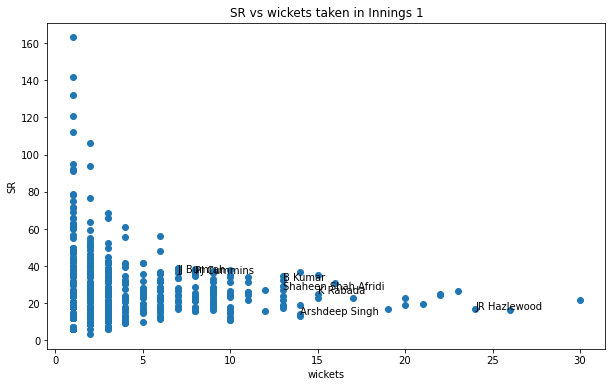

In [ ]:
plt.figure(figsize=(10, 6))

plt.scatter(bdfpp['wickets'], bdfpp['SR']) # scatter plot for SR vs wickets taken in the powerplay
plt.xlabel('wickets')
plt.ylabel('SR')
plt.title('SR vs wickets taken in Innings 1') 


selected_bowlers = ['JJ Bumrah', 'K Rabada', 'Shaheen Shah Afridi', 'Arshdeep Singh', 'JR Hazlewood', 'B Kumar', 'PJ Cummins'] # list of selected bowlers
annotations = list(bdfpp['bowler']) # list of bowlers

for i, j in enumerate(annotations): # annotate the selected bowlers
  if j in selected_bowlers: 
    plt.annotate(j, (bdfpp['wickets'][i], bdfpp['SR'][i]))


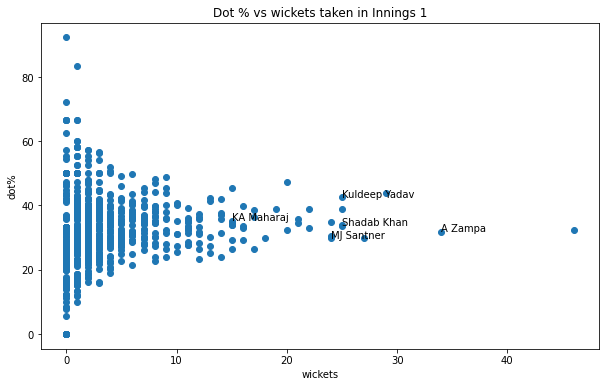

In [ ]:
plt.figure(figsize=(10, 6))

plt.scatter(bdfmo['wickets'], bdfmo['dot%'])  # scatter plot of wickets vs dot%
plt.xlabel('wickets')
plt.ylabel('dot%')
plt.title('Dot % vs wickets taken in Innings 1') 


selected_bowlers = ['A Zampa', 'Kuldeep Yadav', 'MJ Santner', 'KA Maharaj', 'Shadab Khan', 'Rashid Khan'] # select bowlers to annotate
annotations = list(bdfmo['bowler']) # get the list of bowlers

for i, j in enumerate(annotations): # loop through the bowlers
  if j in selected_bowlers: 
    plt.annotate(j, (bdfmo['wickets'][i], bdfmo['dot%'][i]))


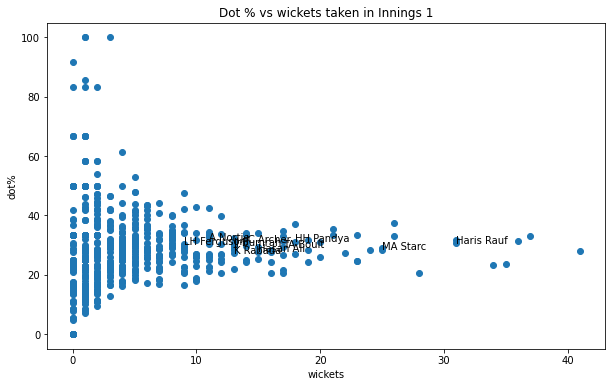

In [ ]:
plt.figure(figsize=(10, 6))

plt.scatter(bdfdo['wickets'], bdfdo['dot%']) # scatter plot of wickets vs dot%
plt.xlabel('wickets')
plt.ylabel('dot%')
plt.title('Dot % vs wickets taken in Innings 1')


selected_bowlers = ['A Nortje', 'HH Pandya', 'Haris Rauf', 'Hasan Ali', 'MA Starc', 'TA Boult', 'LH Ferguson', 'JJ Bumrah', 'JC Archer', 'K Rabada']
annotations = list(bdfdo['bowler'])

for i, j in enumerate(annotations):
  if j in selected_bowlers:
    plt.annotate(j, (bdfdo['wickets'][i], bdfdo['dot%'][i]))

In [41]:
import pandas as pd

def identify_underrated_bowlers(df, min_innings=15, max_innings=40, eco_thresh=30, sr_thresh=30, avg_thresh=30, dot_pct_thresh=70):
    """
    Identifies underrated bowlers based on percentile rankings of key metrics.

    Parameters:
    - df: DataFrame containing bowler statistics.
    - min_innings: Minimum innings a bowler must have played to be considered.
    - max_innings: Maximum innings limit to focus on relatively overlooked bowlers.
    - eco_thresh: Percentile threshold for Economy Rate (lower is better).
    - sr_thresh: Percentile threshold for Strike Rate (lower is better).
    - avg_thresh: Percentile threshold for Bowling Average (lower is better).
    - dot_pct_thresh: Percentile threshold for Dot Ball Percentage (higher is better).

    Returns:
    - DataFrame of underrated bowlers meeting the criteria.
    """

    # Ensure column names are standardized (convert all to uppercase)
    df = df.rename(columns=str.upper)  # Convert all column names to uppercase

    # Filter bowlers based on innings played (to avoid extreme cases)
    df = df[(df["INNINGS"] >= min_innings) & (df["INNINGS"] <= max_innings)]

    # Calculate Percentile Ranks
    df["ECO_PERCENTILE"] = df["ECO"].rank(pct=True) * 100  # Lower is better
    df["SR_PERCENTILE"] = df["SR"].rank(pct=True) * 100    # Lower is better
    df["AVG_PERCENTILE"] = df["AVG"].rank(pct=True) * 100  # Lower is better
    df["DOT_PCT_PERCENTILE"] = df["DOT%"].rank(pct=True) * 100  # Higher is better

    # Count How Many Conditions Each Bowler Meets
    df["NUM_CONDITIONS_MET"] = (
        (df["ECO_PERCENTILE"] < eco_thresh).astype(int) + 
        (df["SR_PERCENTILE"] < sr_thresh).astype(int) + 
        (df["AVG_PERCENTILE"] < avg_thresh).astype(int) + 
        (df["DOT_PCT_PERCENTILE"] > dot_pct_thresh).astype(int)  # Higher Dot% is better
    )

    # Filter bowlers meeting at least 3 conditions
    underrated_bowlers = df[df["NUM_CONDITIONS_MET"] >= 3]

    # Display Summary
    print(f"Players with ECO < {eco_thresh}th percentile: {df[df['ECO_PERCENTILE'] < eco_thresh].shape[0]}")
    print(f"Players with SR < {sr_thresh}th percentile: {df[df['SR_PERCENTILE'] < sr_thresh].shape[0]}")
    print(f"Players with AVG < {avg_thresh}th percentile: {df[df['AVG_PERCENTILE'] < avg_thresh].shape[0]}")
    print(f"Players with Dot% > {dot_pct_thresh}th percentile: {df[df['DOT_PCT_PERCENTILE'] > dot_pct_thresh].shape[0]}")
    print(f"Total Underrated Bowlers (Meeting ≥3 Conditions): {underrated_bowlers.shape[0]}")

    return underrated_bowlers

# Example Usage:
underrated_bowlers = identify_underrated_bowlers(bdfpp)



Players with ECO < 30th percentile: 38
Players with SR < 30th percentile: 38
Players with AVG < 30th percentile: 38
Players with Dot% > 70th percentile: 39
Total Underrated Bowlers (Meeting ≥3 Conditions): 26
